# PREDICTION DE LA REUSSITE SCOLAIRE

## 1. IMPORT DES LIBRAIRIES

In [170]:
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import joblib


## 2. CHARGEMENT DES DONNÉES

Les deux jeux de données sont concaténés afin de conserver une observation par élève et par matière. Les élèves présents dans les deux fichiers ne sont pas considérés comme des doublons.

In [171]:
# Chargement des données du cursus mathématique et du cursus portugais
df_mat = pd.read_csv("data/student-mat.csv", sep=";") 
df_por = pd.read_csv("data/student-por.csv", sep=";")

# Ajout de la variable source
df_mat["source"] = "mat"
df_por["source"] = "por"

# Fusion des deux jeux de données
df = pd.concat([df_mat, df_por], axis=0, ignore_index=True)


## 3. EXPLORATION DES DONNÉES

### Cellule de travail (brouillon)

In [219]:
df.describe(include="all")

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,goout,Dalc,Walc,health,absences,G1,G2,G3,source,target
count,1044,1044,1044.000000,1044,1044,1044,1044.000000,1044.000000,1044,1044,...,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044,1044.000000
unique,2,2,NaN,2,2,2,NaN,NaN,5,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,GP,F,NaN,U,GT3,T,NaN,NaN,other,other,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,por,NaN
freq,772,591,NaN,759,738,923,NaN,NaN,399,584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,649,NaN
mean,NaN,NaN,16.726054,NaN,NaN,NaN,2.603448,2.387931,NaN,NaN,...,3.156130,1.494253,2.284483,3.543103,4.434866,11.213602,11.246169,11.341954,NaN,0.779693
std,NaN,NaN,1.239975,NaN,NaN,NaN,1.124907,1.099938,NaN,NaN,...,1.152575,0.911714,1.285105,1.424703,6.210017,2.983394,3.285071,3.864796,NaN,0.414652
min,NaN,NaN,15.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,NaN,NaN,16.000000,NaN,NaN,NaN,2.000000,1.000000,NaN,NaN,...,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000,NaN,1.000000
50%,NaN,NaN,17.000000,NaN,NaN,NaN,3.000000,2.000000,NaN,NaN,...,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000,NaN,1.000000
75%,NaN,NaN,18.000000,NaN,NaN,NaN,4.000000,3.000000,NaN,NaN,...,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000,NaN,1.000000


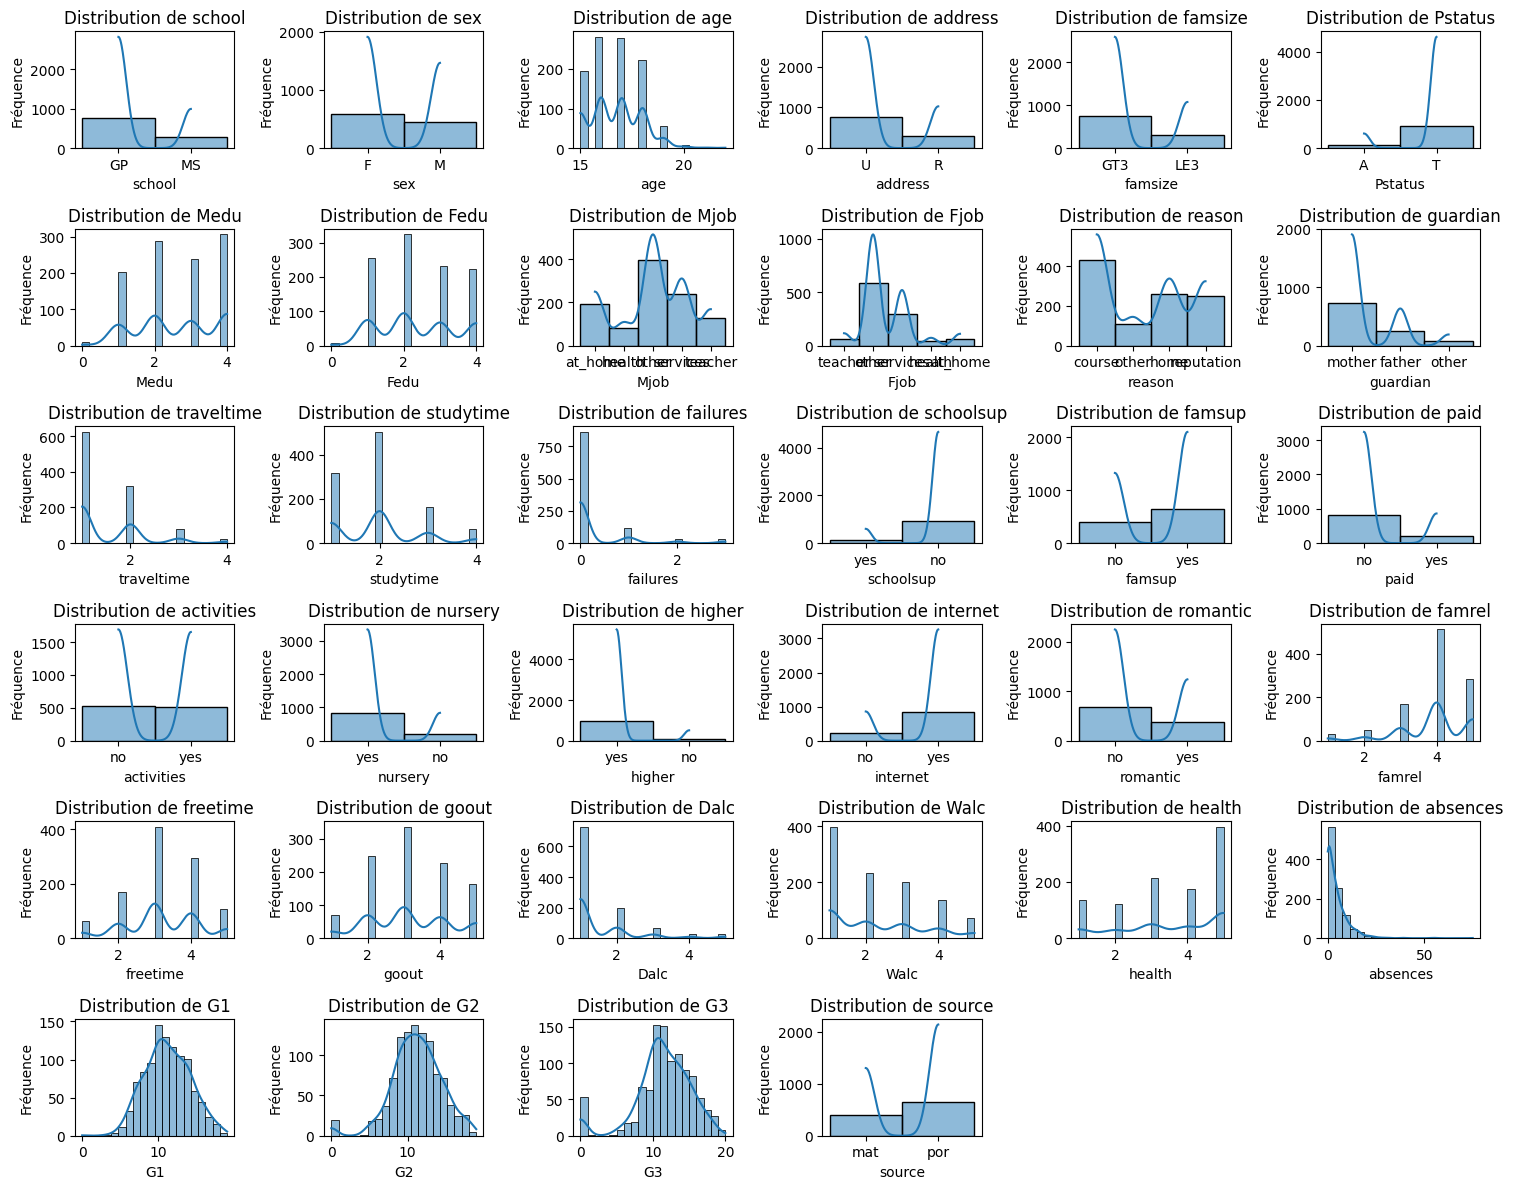

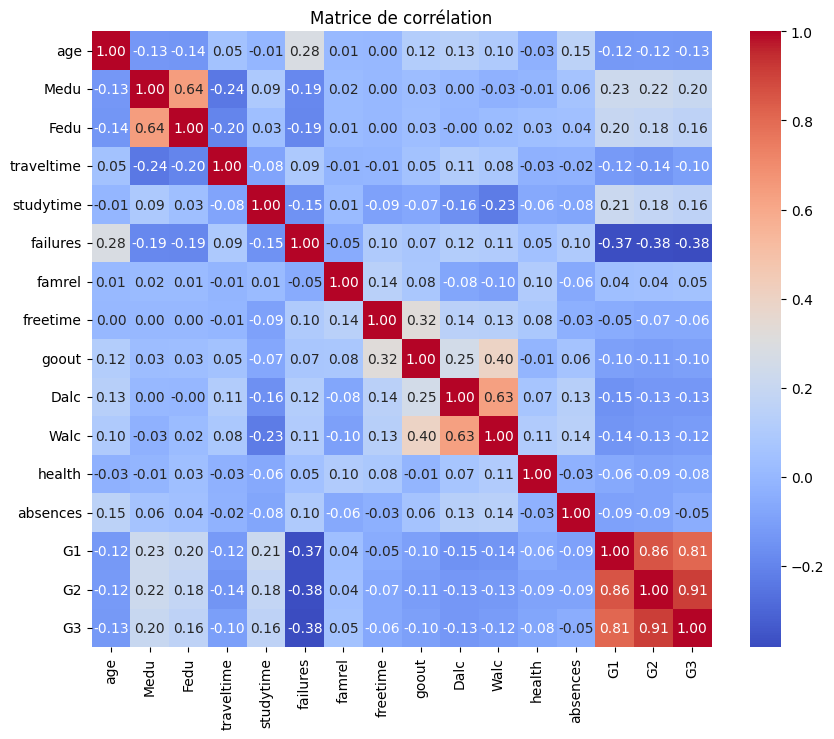

In [9]:
# Affichage de la distribution des données
plt.figure(figsize=(15, 12))

for i, col in enumerate(df.columns, 1):
    plt.subplot(6, 6, i)     # 6x6 pour rentrer les 34 colonnes
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()# Heatmap de corrélation
plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

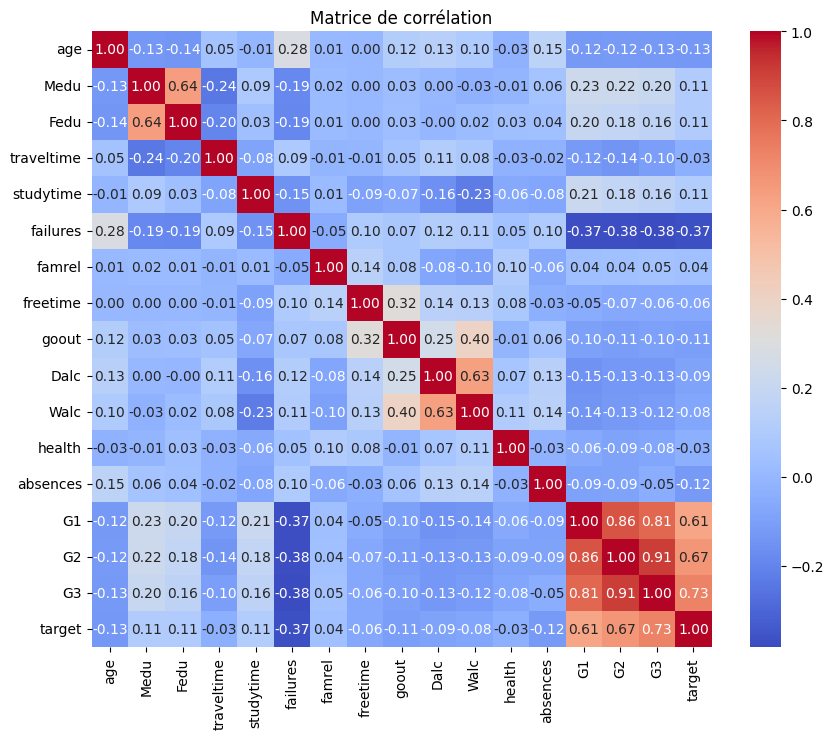

In [199]:
# Heatmap de corrélation
plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

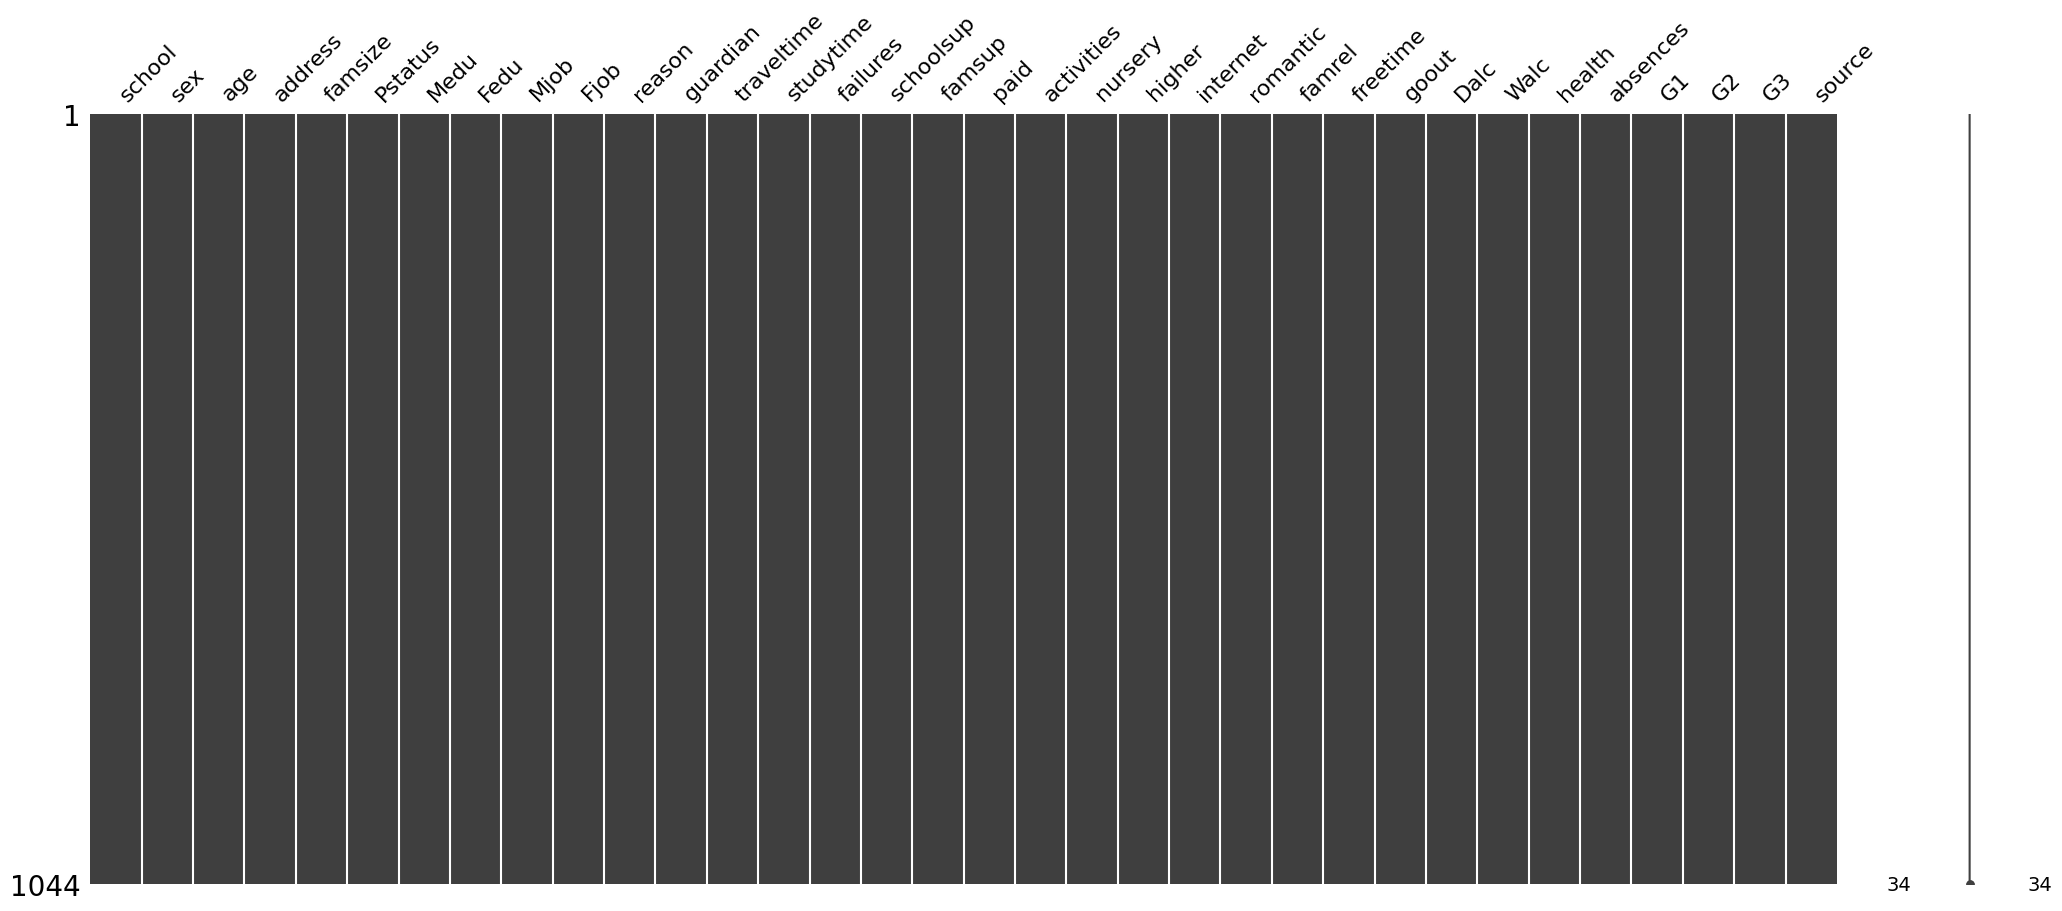

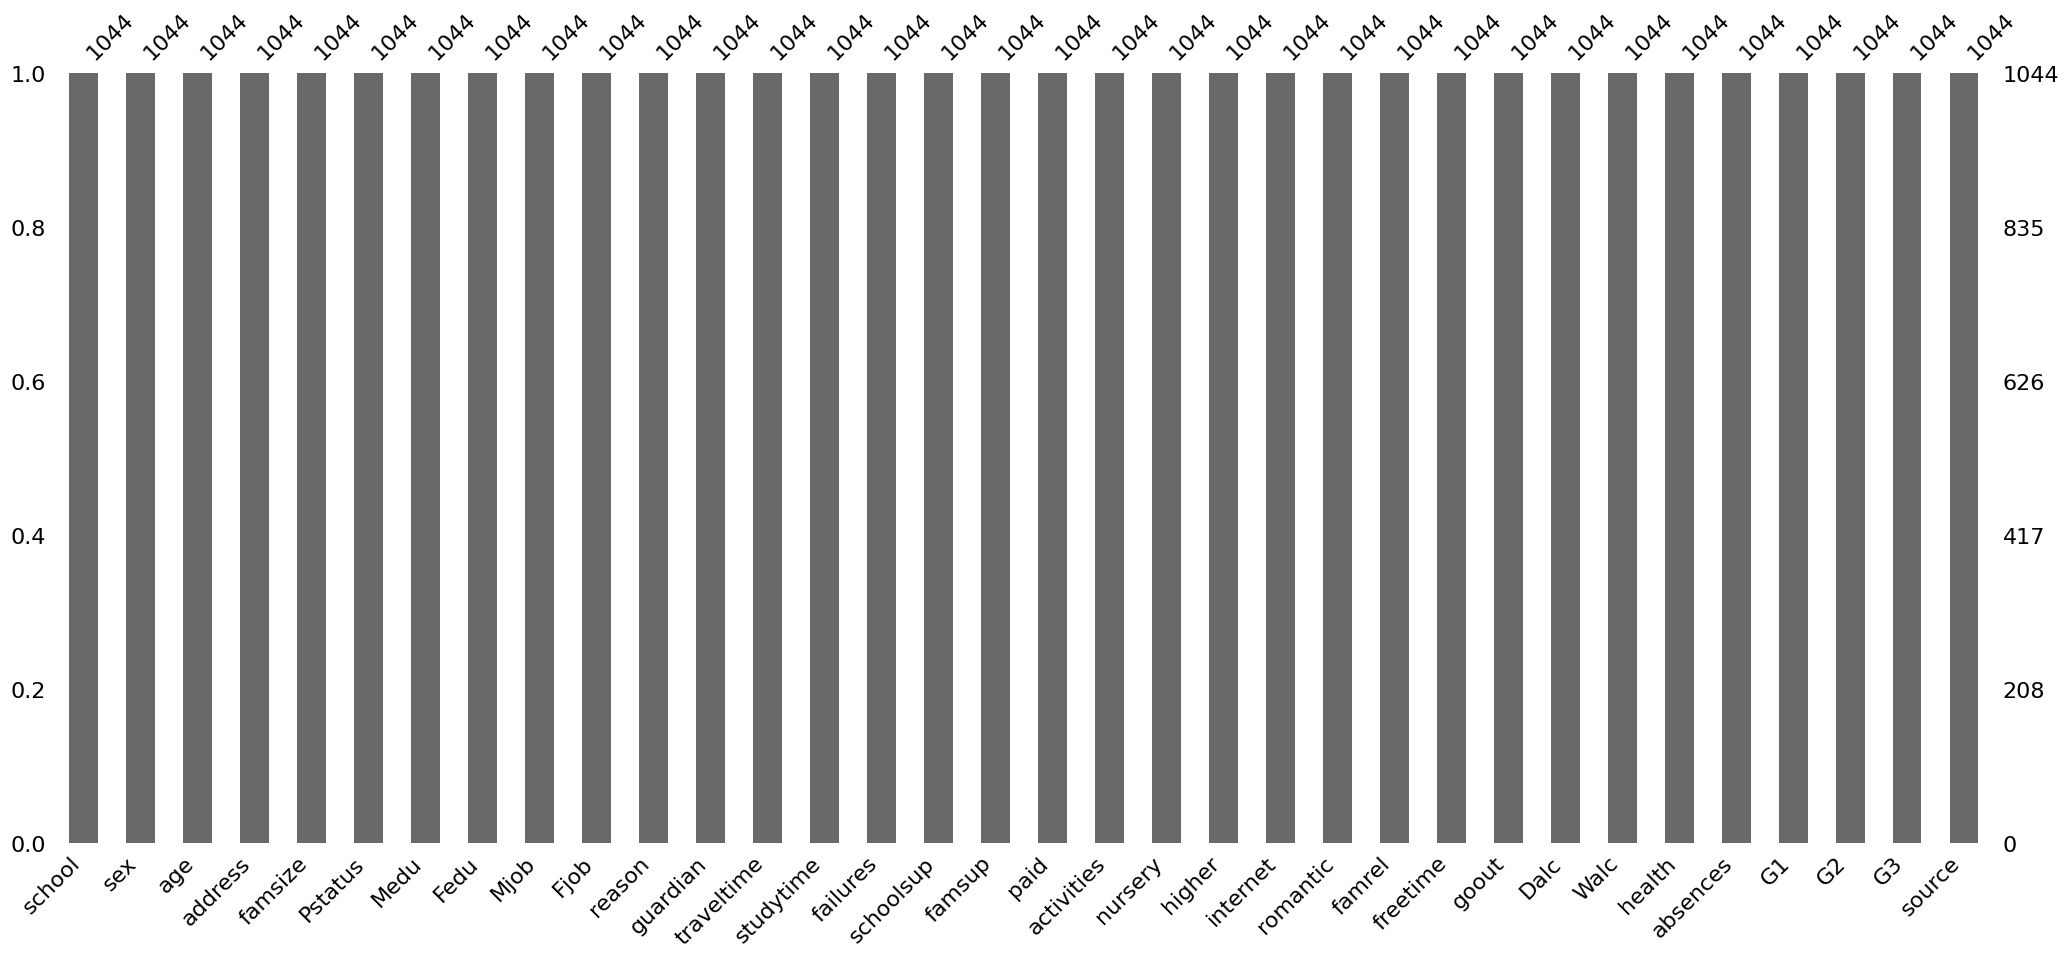

Nb lignes manquantes : 0 / 1044


In [9]:
# Visualiser la matrice des valeurs manquantes
msno.matrix(df)
plt.show()

# Visualiser le barplot des colonnes manquantes
msno.bar(df)
plt.show()

# Nombre de lignes avec au moins une valeur manquante
missing_line = df.isna().any(axis=1).sum()
total_line = df.shape[0]
print(f"Nb lignes manquantes : {missing_line} / {total_line}")


### Cellule de restition du travail

In [172]:
# Vérification
print("Dimensions du dataset :", df.shape)
df["source"].value_counts()
#print("Type de données :", df.dtypes)


Dimensions du dataset : (1044, 34)


source
por    649
mat    395
Name: count, dtype: int64

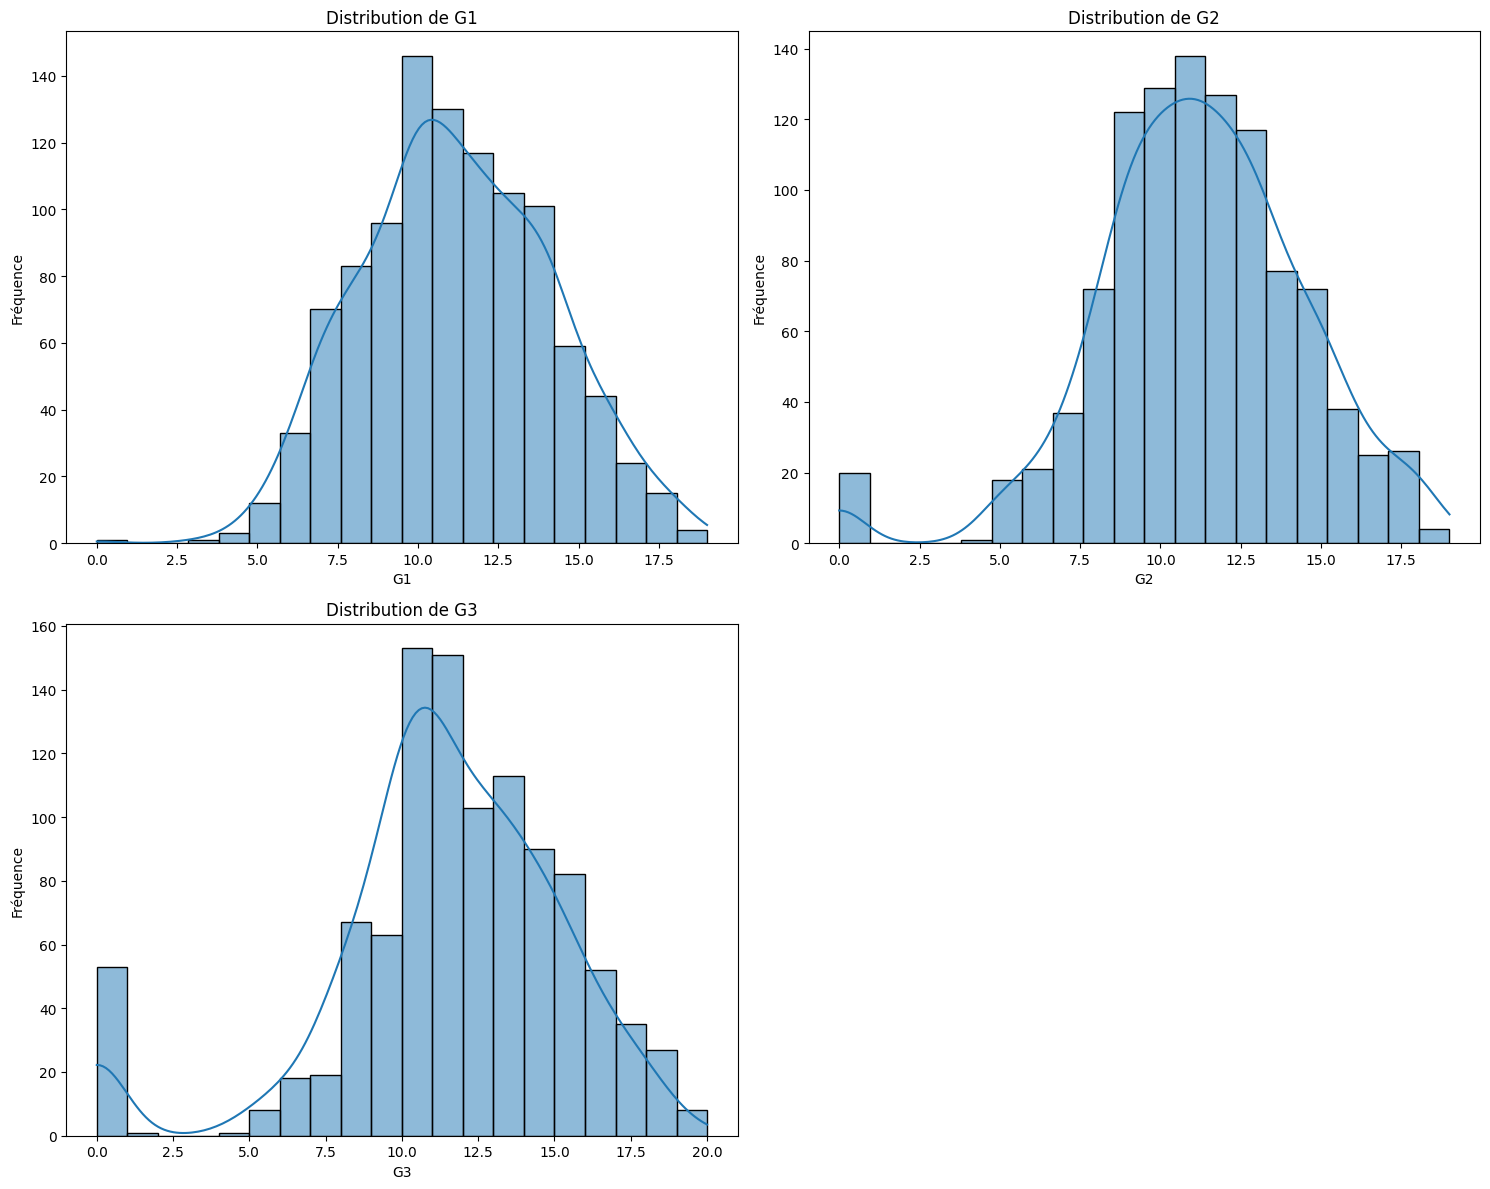

In [173]:
# Affichage de la distribution des données pertinentes
plt.figure(figsize=(15, 12))

# Les histogrammes sont construits avec 20 classes afin de correspondre à l’échelle de notation scolaire et de faciliter l’interprétation.
for i, col in enumerate(["G1", "G2", "G3"], 1):
    plt.subplot(2, 2, i)     # affichage 2x2
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()


Les valeurs nulles observées dans les variables G1, G2 et G3 correspondent à des notes réelles attribuées aux élèves et ne constituent pas des valeurs manquantes. Elles traduisent des situations d’échec total ou d’absence à l’évaluation et seront donc conservées telles quelles dans le jeu de données.

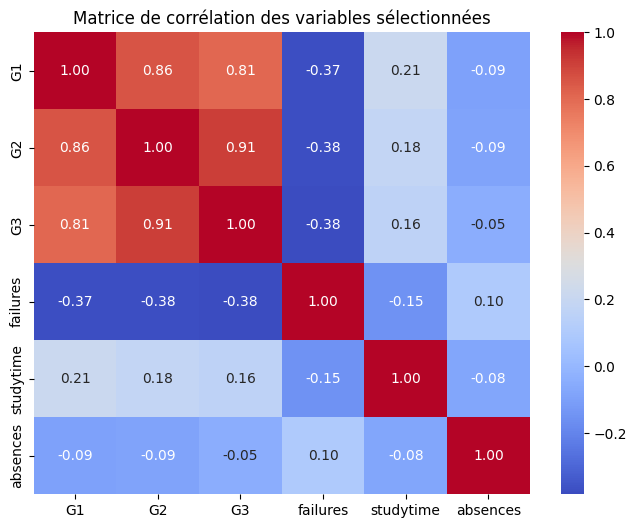

In [174]:
# Heatmap de corrélation

# Variables pertinentes
vars_corr = [
    "G1",
    "G2",
    "G3",
    "failures",
    "studytime",
    "absences"
]

# Ignorer les variables non numérique
corr = df[vars_corr].corr()

# Affichage
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation des variables sélectionnées")
plt.show()

## 4. PRÉPARATIONS DES DONNÉES

### Identification des variables sensibles

In [175]:
# Liste des variables sensibles (information explicite et immédiatement interprétable)
variables_sensibles = [
    "sex", # Sexe de l’élève : F (fille) ou M (garçon)
    "age", # Âge de l’élève (entre 15 et 22 ans)
    "address", # Type d’habitation : U (urbain) ou R (rural)
    "Pstatus", # Statut marital des parents : T (ensemble) ou A (séparés)
    "Mjob", # Profession de la mère (enseignant, santé, services, à domicile, autre)
    "Fjob", # Profession du père (idem Mjob)
    "guardian", # Tuteur/tutrice principal(e) : mère, père ou autre
    "romantic", # En couple ou non (yes/no)
    "health" # État de santé (1= très mauvais, 5= excellent)
]

# Liste des variables indirectes (information agrégée ou abstraite servant de proxy)
variables_indirectes = [
    "school", # École fréquentée : GP (Gabriel Pereira) ou MS (Mousinho da Silveira)
    "reason", # Raison du choix de l’école : proximité, réputation, etc.
    "nursery", # Fréquentation d’une maternelle (yes/no)
    "traveltime", # Temps de trajet domicile-école (1= <15 min, 4= >1h)
    "schoolsup", # Soutien scolaire supplémentaire (yes/no)
    "famsup", # Soutien familial (yes/no)
    "Medu", # Niveau d’éducation de la mère (0 à 4)
    "Fedu", # Niveau d’éducation du père (0 à 4)
    "famsize" # Taille de la famille : LE3 (≤3) ou GT3 (>3) personnes
    "internet", # Accès à internet à la maison (yes/no)
    "paid" # Cours payants en maths (yes/no)
]

# Variables comportementales potentiellement sensibles
variables_comportementales = [
    "Dalc", # consommation d’alcool en semaine (1= très faible à 5= très élevée)
    "Walc" # consommation d’alcool le week-end (1 à 5)
]


### Création de la variable cible

In [209]:
# La variable cible est définie comme une classification binaire indiquant la réussite scolaire (1 si G3 ≥ 10, 0 sinon)
df["target"] = (df["G3"] >= 10).astype(int)

# Scénario 1 — Toutes les variables
X_s1 = df.drop(columns=["G3", "target"])

# Scénario 2 — Sans variables sensibles directes
X_s2 = X_s1.drop(columns=variables_sensibles, errors="ignore")
X_s2 = X_s2.drop(columns=variables_indirectes, errors="ignore")
X_s2 = X_s2.drop(columns=variables_comportementales, errors="ignore")

# Scénario 3 — Sans sensibles + sans G2
X_s3 = X_s2.drop(columns=["G2"], errors="ignore")

# Scénario 4 — Sans sensibles + sans G1 et G2
X_s4 = X_s2.drop(columns=["G1", "G2"], errors="ignore")

# Il n'y a pas de données manquantes dans les jeux fournis

# Préparation de l’encodage : séparation variables numériques / catégorielles
cat_features = X_s1.select_dtypes(include="object").columns.tolist()
num_features = X_s1.select_dtypes(exclude="object").columns.tolist()

# Les variables numériques sont standardisées, tandis que les variables catégorielles sont encodées par one-hot encoding 
# afin de permettre leur utilisation par les modèles de classification.
# Il faut un preprocessor par scénario, construit à partir des colonnes du scénario.
def make_preprocessor(X):
    cat_features = X.select_dtypes(include="object").columns.tolist()
    num_features = X.select_dtypes(exclude="object").columns.tolist()

    return ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
        ]
    )

## 5.MODÉLISATION

### Séparation des données (train / test)

In [210]:
y = df["target"]

X_train_s1, X_test_s1, y_train, y_test = train_test_split(
    X_s1, y, test_size=0.2, random_state=42, stratify=y
)

X_train_s2, X_test_s2, _, _ = train_test_split(
    X_s2, y, test_size=0.2, random_state=42, stratify=y
)

X_train_s3, X_test_s3, _, _ = train_test_split(
    X_s3, y, test_size=0.2, random_state=42, stratify=y
)

X_train_s4, X_test_s4, _, _ = train_test_split(
    X_s4, y, test_size=0.2, random_state=42, stratify=y
)


#### Fonction générique : création du pipeline

In [202]:
# Un pipeline est défini afin d’intégrer le prétraitement des données et le modèle de classification au sein d’un même objet,
# ce qui garantit la reproductibilité et évite les fuites de données.
# Le jeu de données et les modèles à tester sont passées en paramètres
def make_pipeline_for_model(X, model):
    return Pipeline(
        steps=[
            ("preprocessor", make_preprocessor(X)),
            ("model", model)
        ]
    )

### Modèle de référence (baseline) - Régression logistique

In [179]:
# Le modèle choisi comme référence est une régression logistique en raison de sa simplicité et de son caractère interprétable.

log_reg = LogisticRegression(max_iter=1000)


### Modèle d’ensemble — Random Forest

In [180]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)


### Modèle d’ensemble — Gradient Boosting

In [181]:

gb = GradientBoostingClassifier(random_state=42)


### Fonction générique d'évaluation

In [211]:
# Le F1-score est utilisé comme métrique principale car il permet de prendre en compte à la fois la précision et le rappel, et constitue une
# mesure plus adaptée qu’une simple accuracy dans un contexte de classes légèrement déséquilibrées.

# cross_val_score appelle pipeline.fit, pipeline.predict et réalise la validation croisée en 5 plis (cv=5)
# le F1-score final est la moyenne des 5 évaluations
def evaluate_model(pipeline, X, y):
    scores = cross_val_score(
        pipeline,
        X,
        y,
        cv=5,
        scoring="f1"
    )
    return scores.mean()


### Évaluation par scénario

#### Scénario 1 — Toutes les variables

In [212]:
pipelines_s1 = {
    "Logistic Regression": make_pipeline_for_model(X_s1, log_reg),
    "Random Forest": make_pipeline_for_model(X_s1, rf),
    "Gradient Boosting": make_pipeline_for_model(X_s1, gb),
}


#### Scénario 2 — Sans variables sensibles

In [213]:
pipelines_s2 = {
    "Logistic Regression": make_pipeline_for_model(X_s2, log_reg),
    "Random Forest": make_pipeline_for_model(X_s2, rf),
    "Gradient Boosting": make_pipeline_for_model(X_s2, gb),
}


#### Scénario 3 — Sans sensibles + sans G2

In [214]:
pipelines_s3 = {
    "Logistic Regression": make_pipeline_for_model(X_s3, log_reg),
    "Random Forest": make_pipeline_for_model(X_s3, rf),
    "Gradient Boosting": make_pipeline_for_model(X_s3, gb),
}


#### Scénario 4 — Sans sensibles + sans G1 et G2

In [215]:
pipelines_s4 = {
    "Logistic Regression": make_pipeline_for_model(X_s4, log_reg),
    "Random Forest": make_pipeline_for_model(X_s4, rf),
    "Gradient Boosting": make_pipeline_for_model(X_s4, gb),
}


#### Résultats

In [216]:
results = []

# Pour chaque scénario on évalue les 3 modèles
for scenario_name, scenario_desc, pipelines, X in [
    ("Scenario 1", "Toutes les variables disponibles", pipelines_s1, X_s1),
    ("Scenario 2", "Sans variables sensibles", pipelines_s2, X_s2),
    ("Scenario 3", "Sans variables sensibles et sans G2", pipelines_s3, X_s3),
    ("Scenario 4", "Sans variables sensibles, sans G1 et G2", pipelines_s4, X_s4),
]:
    for model_name, pipeline in pipelines.items():
        score = evaluate_model(pipeline, X, y)
        results.append({
            "Scenario": scenario_name,
            "Description": scenario_desc,
            "Model": model_name,
            "F1-score (CV)": score
        })


In [217]:
results_df = pd.DataFrame(results)
results_df


,Scenario,Description,Model,F1-score (CV)
0,Scenario 1,Toutes les variables disponibles,Logistic Regression,0.925857
1,Scenario 1,Toutes les variables disponibles,Random Forest,0.919418
2,Scenario 1,Toutes les variables disponibles,Gradient Boosting,0.915936
3,Scenario 2,Sans variables sensibles,Logistic Regression,0.937587
4,Scenario 2,Sans variables sensibles,Random Forest,0.937256
5,Scenario 2,Sans variables sensibles,Gradient Boosting,0.938067
6,Scenario 3,Sans variables sensibles et sans G2,Logistic Regression,0.911631
7,Scenario 3,Sans variables sensibles et sans G2,Random Forest,0.916314
8,Scenario 3,Sans variables sensibles et sans G2,Gradient Boosting,0.907838
9,Scenario 4,"Sans variables sensibles, sans G1 et G2",Logistic Regression,0.875647


Les résultats montrent que les modèles ont des performances proches, mais que globalement la régression logistique reste légèrement plus performante.
Le retrait des variables sensibles ne réduit pas les performances, on constate même une légère amélioration, suggérant que ces variables n’apportent rien pour la prédiction.
Lorsque les notes intermédiaires sont supprimées, les performances diminuent de manière attendue, mais la régression logistique reste relativement robuste, contrairement aux modèles plus complexes, lorsque G2 et G1 ne sont pas connu.


In [222]:
# On enregistre les deux modèles suivants pour la phase industrialisation

# Régression logistique avec note du deuxième trimestre
whith_g2_pipeline = make_pipeline_for_model(X_s2, log_reg)
whith_g2_pipeline.fit(X_s2, y)
joblib.dump(whith_g2_pipeline, "model_with_g2.pkl")

# Régression logistique sans note du deuxième trimestre
whithout_g2_pipeline = make_pipeline_for_model(X_s3, log_reg)
whithout_g2_pipeline.fit(X_s3, y)
joblib.dump(whithout_g2_pipeline, "model_without_g2.pkl")

['model_without_g2.pkl']